In [1]:
import pandas as pd
import os
import re
import numpy as np
from numpy import inf
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import warnings
import six
warnings.filterwarnings("ignore")
%matplotlib inline

# Funções 

In [2]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    ''' Renderiza um Dataframe'''
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

In [3]:
def plot_asa(geo, position=[1,1,1], figure=0, grade=True, color=0, sections=False):
    # Recebe o "df.iloc[x]"
    
    geracao = geo[10]
    geo = list(geo)[0:10]   
    
    envs = geo[0:3]
    cordas = geo[3:7]
    offsets = geo[7:]
    
    if figure == 0:
        fig = plt.figure()
    else:
        fig = figure
        
    ax = fig.add_subplot(*position, aspect='equal')
        
    if sections ==False:
        x = [0,envs[0],envs[1],envs[2],envs[2],envs[1],envs[0],0]
        y = [0,offsets[0],offsets[1],offsets[2],offsets[2]+cordas[-1],offsets[1]+cordas[-2],offsets[0]+cordas[-3],cordas[-4]]
        ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False))
    
    else:
        # Seção 1
        x = [0,envs[0],envs[0],0]
        y = [0,offsets[0],offsets[0]+cordas[-3],cordas[-4]]
        ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False))
        
        # Seção 2
        x = [envs[0],envs[1],envs[1],envs[0]]
        y = [offsets[0],offsets[1],offsets[1]+cordas[-2],offsets[0]+cordas[-3]]
        ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False))
        
        # Seção 3
        x = [envs[1],envs[2],envs[2],envs[1]]
        y = [offsets[1],offsets[2], offsets[2]+cordas[-1],offsets[1]+cordas[-2]]
        ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False))        
        
    if (color != 0):
        ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=True, color=color))

    x = [value*-1 for value in x]
    
    ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False))
                 
    if color!= 0:
        ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=True, color=color))

    plt.xlim(min(x)*-1.2, min(x)*1.2)
    plt.ylim(-0.1,max(y)*1.3)
    
    if sections:
        plt.xlim(0, min(x)*1.2*-1)
        
    if grade:
        plt.title(geracao)
        
    else:
        plt.axis('off')

#     plt.show()
#     return (ax)

In [4]:
def checa_sobrevivencia(df):
    df["Sobreviveu"] = ""
    posicao = 0
    for i in range(0, len(df)-1):
        for x,individuo in enumerate([list(linha[:10]) for linha in df[df["Geracao"] == i].values]):
#             filename = df[df["Geracao"] == i].values[x][-3]
            if individuo in [list(linha[:10]) for linha in df[df["Geracao"] == i+1].values]:
#                 df.loc[df["File"]==filename,"Sobreviveu"] = "Sim"
                df.loc[posicao,"Sobreviveu"] = "Sim"
            else:
                df.loc[posicao,"Sobreviveu"] = "Não"
            posicao +=1
    return df

In [5]:
def animacao(df,file= 'animacao_geracoes'):
#     df = checa_sobrevivencia(df)
    directory = "./plot/"
    linhas = 8
    colunas = 5
    for geracao in range (0, df["Geracao"].nunique()-1):
        f = plt.figure(figsize=(15,8))
        atual  = df[df["Geracao"]==geracao].reset_index(drop=True)
        for i in range(1, len(atual)+1):
            plot_asa(atual.iloc[i-1], [linhas, colunas, i], f, grade=False)
            
        plt.savefig(f"{directory}geracao_{geracao}_0.jpeg", transparent=False)
        
        f = plt.figure(figsize=(15,8))
        for i in range(1, len(atual)+1):
            if atual.loc[i-1, "Sobreviveu"] == "Sim":
                plot_asa(atual.iloc[i-1], [linhas, colunas, i], f, grade=False, color="green")
                
            elif atual.loc[i-1, "Sobreviveu"] == "Não":
                plot_asa(atual.iloc[i-1], [linhas, colunas, i], f, grade=False, color="firebrick")
                
        plt.savefig(f"{directory}geracao_{geracao}_1.jpeg", transparent=False)
    
    # Video
    video_name =directory+file+'.mp4'
    images = [img for img in os.listdir(directory) if img.endswith(".jpeg")]
    frame = cv2.imread(os.path.join(directory, images[0]))
    height, width, layers = frame.shape

    df = pd.DataFrame([image.split("_")[1:3]  for image in images], images).reset_index()
    df.columns = ["file", "geracao", "tipo"]
    df["geracao"] = df["geracao"].astype(int)
    df["tipo"] = df["tipo"].str[0].astype(int)
    df = df.sort_values(by=["geracao", "tipo"])
    images_formatos = list(df[df["tipo"]==0]["file"])
    images_cores = list(df[df["tipo"]==1]["file"])
    images = list(df["file"])

    fps = 5
    video = cv2.VideoWriter(video_name, 0, fps, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(directory, image)))

    cv2.destroyAllWindows()
    video.release()

In [24]:
df5.values

,Envergadura_1,Envergadura_2,Envergadura_3,Corda_1,Corda_2,Corda_3,Corda_4,Offset_1,Offset_2,Offset_3,Pontuacao,constraints,objetivos_penalizados,viavel,Area,CL,CD,Massa_Vazia
Geracao,,,,,,,,,,,,,,,,,,
0,0.3408,1.08,2.0775,0.8713,0.6124,0.4528,0.34545,0.073,0.394,0.61275,14.535833,"[4.154999999999999, 0.7392000000000001, 0.9974...",-14.535833,0,2.089295,2.1520,0.1824,9.521252
1,0.3408,1.08,2.0775,0.8713,0.6124,0.4528,0.34545,0.073,0.394,0.61275,14.535833,"[4.154999999999999, 0.7392000000000001, 0.9974...",-14.535833,0,2.089295,2.1520,0.1824,9.521252
2,0.3408,1.08,2.0775,0.8713,0.6124,0.4528,0.34545,0.073,0.394,0.61275,14.535833,"[4.154999999999999, 0.7392000000000001, 0.9974...",-14.535833,0,2.089295,2.1520,0.1824,9.521252
3,0.3408,1.08,2.0775,0.8713,0.6124,0.4528,0.34545,0.073,0.394,0.61275,14.535833,"[4.154999999999999, 0.7392000000000001, 0.9974...",-14.535833,0,2.089295,2.1520,0.1824,9.521252
4,0.3408,1.08,2.0775,0.8713,0.6124,0.4528,0.34545,0.073,0.394,0.61275,14.535833,"[4.154999999999999, 0.7392000000000001, 0.9974...",-14.535833,0,2.089295,2.1520,0.1824,9.521252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.3000,1.08,2.0760,0.4024,0.3312,0.2932,0.13835,0.089,0.160,0.45900,18.401957,"[4.152, 0.78, 0.996, -0.07120000000000004, -0....",-18.401957,0,1.136936,2.4896,0.1293,3.514454
296,0.3000,1.08,2.0760,0.4024,0.3312,0.2932,0.13835,0.089,0.160,0.45900,18.401957,"[4.152, 0.78, 0.996, -0.07120000000000004, -0....",-18.401957,0,1.136936,2.4896,0.1293,3.514454
297,0.3000,1.08,2.0760,0.4024,0.3312,0.2932,0.13835,0.089,0.160,0.45900,18.401957,"[4.152, 0.78, 0.996, -0.07120000000000004, -0....",-18.401957,0,1.136936,2.4896,0.1293,3.514454


In [48]:
def animacao_single(df,file= 'animacao_geracoes'):
    '''
    Só uma asa por frame
    '''
    
    directory = "./plot/"
    linhas = 8
    colunas = 5
    for i in range (0, len(df)):
        _ = plt.figure(figsize=(15,8))
        _ = plot_asa(df.iloc[i], grade=False)
        _ = plt.title(f"Generation: {i}")
        plt.xlim(-3,3)
        plt.ylim(-1,1)
        _ = plt.savefig(f"{directory}geracao_{i}_0.jpeg", transparent=False)
        _ = plt.close()
    
    # Video
    video_name =directory+file+'.mp4'
    images = [img for img in os.listdir(directory) if img.endswith(".jpeg")]
    frame = cv2.imread(os.path.join(directory, images[0]))
    height, width, layers = frame.shape

    df = pd.DataFrame([image.split("_")[1:3]  for image in images], images).reset_index()
    df.columns = ["file", "geracao", "tipo"]
    df["geracao"] = df["geracao"].astype(int)
    df["tipo"] = df["tipo"].str[0].astype(int)
    df = df.sort_values(by=["geracao", "tipo"])
    images_formatos = list(df[df["tipo"]==0]["file"])
    images_cores = list(df[df["tipo"]==1]["file"])
    images = list(df["file"])

    fps = 25
    video = cv2.VideoWriter(video_name, 0, fps, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(directory, image)))

    cv2.destroyAllWindows()
    video.release()

In [ ]:
animacao_single(df5, "absoluto_top")

In [6]:
def ler_logs(arquivo):
    df_final = pd.DataFrame()

    df = pd.read_csv(f"./Resultados/{arquivo}.csv")
    df= df.drop('Unnamed: 0', axis=1)

    for i in ['pop_new', 'objetivos', 'constraints','objetivos_penalizados', 'parameters', 'viavel']:
        df[i] = df[i].apply(lambda x: eval(x))

    variaveis = ["Envergadura_1", "Envergadura_2","Envergadura_3","Corda_1","Corda_2","Corda_3","Corda_4","Offset_1","Offset_2", "Offset_3"]
    geometria = pd.DataFrame(df[["pop_new"]].explode("pop_new")["pop_new"].to_list(), columns= variaveis)
    gen_no = df[["gen_no","pop_new"]].explode("pop_new")["gen_no"]
    df_final = pd.concat([df_final,geometria])
    df_final["Geracao"] = gen_no.reset_index(drop=True)
    df_final["Pontuacao"] = df[["objetivos"]].explode("objetivos")["objetivos"].apply(lambda x: x[0]*-1).reset_index(drop="True")
    df_final["constraints"] =  df[["constraints"]].explode("constraints").reset_index(drop=True)["constraints"]
    df_final["objetivos_penalizados"] = df[["objetivos_penalizados"]].explode("objetivos_penalizados")["objetivos_penalizados"].apply(lambda x: x[0]).reset_index(drop="True")
    df_final["viavel"] = df[["viavel"]].explode("viavel").reset_index(drop=True)["viavel"]
    # ok
    variaveis = ["Area", "CL","CD","Massa_Vazia"]
    resultados = pd.DataFrame(df[["parameters"]].explode("parameters")["parameters"].to_list(), columns= variaveis)
    df_final = pd.concat([df_final, resultados], axis=1)
    
    return df_final

# Leitura de dados

In [8]:
# df = ler_logs("Absoluto_20_300_MaxPontuacao_R5")
df1 = ler_logs("Absoluto_20_300_MaxPontuacao_R1")
df2 = ler_logs("Absoluto_20_300_MaxPontuacao_R2")
df3 = ler_logs("Absoluto_20_300_MaxPontuacao_R3")
df4 = ler_logs("Absoluto_20_300_MaxPontuacao_R4")
df5 = ler_logs("Absoluto_20_300_MaxPontuacao_R5")

# Para relativo
def trata_relativo(df):
    df["Envergadura_2"] = df["Envergadura_1"] + df["Envergadura_2"]
    df["Envergadura_3"] = df["Envergadura_2"] + df["Envergadura_3"]

    df["Corda_2"] = df["Corda_1"] - df["Corda_2"]
    df["Corda_3"] = df["Corda_2"] - df["Corda_3"]
    df["Corda_4"] = df["Corda_3"] - df["Corda_4"]

    df["Offset_2"] = df["Offset_1"] + df["Offset_2"]
    df["Offset_3"] = df["Offset_2"] + df["Offset_3"]

    return df

dfr1 = trata_relativo(ler_logs("Relativo_20_300_MaxPontuacao_R1"))
dfr2 = trata_relativo(ler_logs("Relativo_20_300_MaxPontuacao_R2"))
dfr3 = trata_relativo(ler_logs("Relativo_20_300_MaxPontuacao_R3"))
dfr4 = trata_relativo(ler_logs("Relativo_20_300_MaxPontuacao_R4"))
dfr5 = trata_relativo(ler_logs("Relativo_20_300_MaxPontuacao_R5"))
# ultima = df[df["Geracao"]==299]

In [13]:
# Isso é para exportar o melhor individuo de cada geração (para cada R)

dfr1 = dfr1.sort_values(["Geracao","Pontuacao"]).groupby("Geracao").last()#.to_csv("Max_payload_relativo_R1.csv")
dfr2 = dfr2.sort_values(["Geracao","Pontuacao"]).groupby("Geracao").last()#.to_csv("Max_payload_relativo_R2.csv")
dfr3 = dfr3.sort_values(["Geracao","Pontuacao"]).groupby("Geracao").last()#.to_csv("Max_payload_relativo_R3.csv")
dfr4 = dfr4.sort_values(["Geracao","Pontuacao"]).groupby("Geracao").last()#.to_csv("Max_payload_relativo_R4.csv")
dfr5 = dfr5.sort_values(["Geracao","Pontuacao"]).groupby("Geracao").last()#.to_csv("Max_payload_relativo_R5.csv")

df1 = df1.sort_values(["Geracao","Pontuacao"]).groupby("Geracao").last()#.to_csv("Max_payload_absoluto_R1.csv")
df2 = df2.sort_values(["Geracao","Pontuacao"]).groupby("Geracao").last()#.to_csv("Max_payload_absoluto_R2.csv")
df3 = df3.sort_values(["Geracao","Pontuacao"]).groupby("Geracao").last()#.to_csv("Max_payload_absoluto_R3.csv")
df4 = df4.sort_values(["Geracao","Pontuacao"]).groupby("Geracao").last()#.to_csv("Max_payload_absoluto_R4.csv")
df5 = df5.sort_values(["Geracao","Pontuacao"]).groupby("Geracao").last()#.to_csv("Max_payload_absoluto_R5.csv")

# Visualiações 

In [ ]:
for i in range(0, len(ultima)):
    plot_asa(ultima.iloc[i])

(14.0, 19.0)

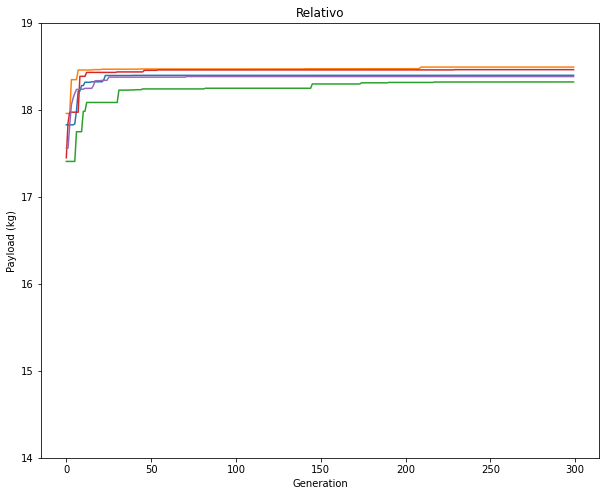

In [11]:
# Relativo
plt.figure(figsize=(10,8))

viavel1 = dfr1[dfr1["viavel"]==0]
viavel2 = dfr2[dfr2["viavel"]==0]
viavel3 = dfr3[dfr3["viavel"]==0]
viavel4 = dfr4[dfr4["viavel"]==0]
viavel5 = dfr5[dfr5["viavel"]==0]

viavel1.groupby("Geracao").max()["Pontuacao"].plot()
viavel2.groupby("Geracao").max()["Pontuacao"].plot()
viavel3.groupby("Geracao").max()["Pontuacao"].plot()
viavel4.groupby("Geracao").max()["Pontuacao"].plot()
viavel5.groupby("Geracao").max()["Pontuacao"].plot()

# viavel1.groupby("Geracao").max().to_csv("melhores_relativo_r1.csv")
# viavel2.groupby("Geracao").max().to_csv("melhores_relativo_r2.csv")
# viavel3.groupby("Geracao").max().to_csv("melhores_relativo_r3.csv")
# viavel4.groupby("Geracao").max().to_csv("melhores_relativo_r4.csv")
# viavel5.groupby("Geracao").max().to_csv("melhores_relativo_r5.csv")


relativo_total = pd.concat([viavel1,viavel2,viavel3,viavel4,viavel5])

plt.title("Relativo")
plt.xlabel("Generation")
plt.ylabel("Payload (kg)")
plt.ylim(14,19)

(14.0, 19.0)

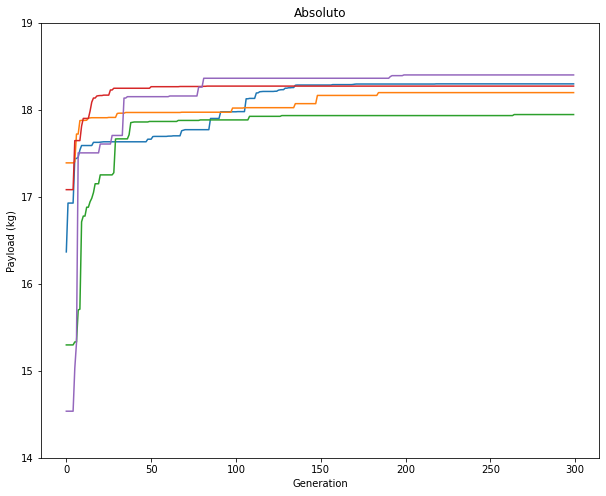

In [12]:
# Absoltuo
plt.figure(figsize=(10,8))

viavel1 = df1[df1["viavel"]==0]
viavel2 = df2[df2["viavel"]==0]
viavel3 = df3[df3["viavel"]==0]
viavel4 = df4[df4["viavel"]==0]
viavel5 = df5[df5["viavel"]==0]

viavel1.groupby("Geracao").max()["Pontuacao"].plot()
viavel2.groupby("Geracao").max()["Pontuacao"].plot()
viavel3.groupby("Geracao").max()["Pontuacao"].plot()
viavel4.groupby("Geracao").max()["Pontuacao"].plot()
viavel5.groupby("Geracao").max()["Pontuacao"].plot()

# viavel1.groupby("Geracao").max().to_csv("melhores_absoluto_r1.csv")
# viavel2.groupby("Geracao").max().to_csv("melhores_absoluto_r2.csv")
# viavel3.groupby("Geracao").max().to_csv("melhores_absoluto_r3.csv")
# viavel4.groupby("Geracao").max().to_csv("melhores_absoluto_r4.csv")
# viavel5.groupby("Geracao").max().to_csv("melhores_absoluto_r5.csv")

absoluto_total = pd.concat([viavel1,viavel2,viavel3,viavel4,viavel5])

plt.title("Absoluto")
plt.xlabel("Generation")
plt.ylabel("Payload (kg)")
plt.ylim(14,19)

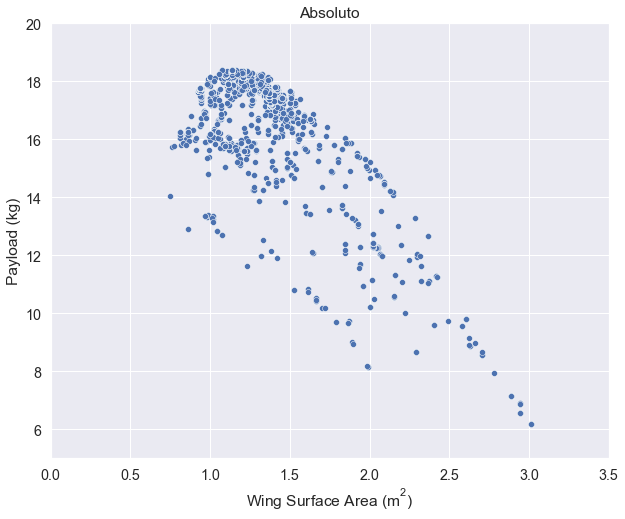

In [123]:
sns.set(font_scale = 1.3)
plt.figure(figsize=(10,8))
sns.scatterplot(data= absoluto_total, x="Area", y="Pontuacao", alpha=1, palette=['black'])

plt.xlabel("Wing Surface Area ($\mathregular{m^{2}}$)")
plt.ylabel("Payload (kg)")
plt.title("Absoluto")

_ = plt.xlim(0,3.5)
_ = plt.ylim(5,20)

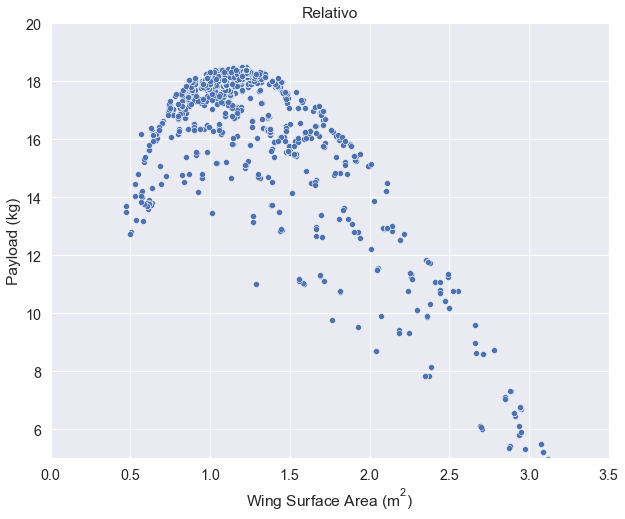

In [127]:
plt.figure(figsize=(10,8))
sns.set(font_scale = 1.3)
sns.scatterplot(data= relativo_total, x="Area", y="Pontuacao")
plt.ylim(0)
plt.xlabel("Wing Surface Area ($\mathregular{m^{2}}$)")
plt.ylabel("Payload (kg)")
plt.title("Relativo")
_ = plt.xlim(0,3.5)
_ = plt.ylim(5,20)

In [ ]:
dfr2
df5

In [22]:
df = checa_sobrevivencia(df)
animacao(df)

# Misc

In [86]:
import plotly.express as px
import pandas as pd
df = pd.DataFrame(dict(
    r=[1, 5, 2, 2, 3],
    theta=['processing cost','mechanical properties','chemical stability',
           'thermal stability', 'device integration']))
fig = px.line_polar(df, r='r', theta='theta', line_close=True)
fig.show()